# Mediapipe inference on static Yoga pose image dataset

In [2]:
import json
import cv2

def load_coco_annotations(coco_json_path):
    with open(coco_json_path) as f:
        coco_data = json.load(f)
    return coco_data

# Replace with your JSON file path
coco_json_path = 'Yoga poses.v2i.coco/test/_annotations.coco.json'
coco_data = load_coco_annotations(coco_json_path)

## Loading model

In [3]:
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    return results, image_rgb

# Replace with your image path
image_path = 'Yoga poses.v2i.coco/test/test1.jpg'
results, image_rgb = process_image(image_path)

2024-08-23 19:06:02.097297: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 19:06:02.125362: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 19:06:02.126302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 19:06:02.652506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1724450763.621695   12924 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1724450763.695654   12995 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 3070/PCIe/SSE2
INFO: Created TensorFlow Lite X

## Dataset pre-processing

In [5]:
def extract_mediapipe_keypoints(results, image_shape):
    if results.pose_landmarks:
        keypoints = []
        for landmark in results.pose_landmarks.landmark:
            x = int(landmark.x * image_shape[1])
            y = int(landmark.y * image_shape[0])
            keypoints.append((x, y))
        return keypoints
    else:
        return [(0, 0)] * 17  # assuming 17 keypoints in COCO format

image_shape = (image_rgb.shape[0], image_rgb.shape[1])
mp_keypoints = extract_mediapipe_keypoints(results, image_shape)


def filter_keypoints(results, indices):
    if results.pose_landmarks:
        keypoints = []
        for i in indices:
            landmark = results.pose_landmarks.landmark[i]
            x, y = int(landmark.x * image_width), int(landmark.y * image_height)
            keypoints.append((x, y))
        return keypoints
    return None

# Define the indices for the 13 keypoints we need
# Using MediaPipe indices: 
# 0: Nose, 11: Left Shoulder, 12: Right Shoulder, 23: Left Hip, 24: Right Hip, 
# 25: Left Knee, 26: Right Knee, 27: Left Ankle, 28: Right Ankle, 13: Left Elbow, 14: Right Elbow,
# 15: Left Wrist, 16: Right Wrist

selected_indices = [0, 11, 12, 23, 24, 25, 26, 27, 28, 13, 14, 15, 16]

# Process the image and filter the keypoints
image_height, image_width, _ = image_rgb.shape
mp_keypoints = filter_keypoints(results, selected_indices)

def coco_keypoints_to_xy(keypoints, image_width, image_height):
    xy_keypoints = []
    for i in range(0, len(keypoints), 3):
        x = keypoints[i]
        y = keypoints[i+1]
        xy_keypoints.append((x, y))
    return xy_keypoints

# Example for a single annotation (loop through multiple if needed)
gt_ann = coco_data['annotations'][0]
gt_keypoints = coco_keypoints_to_xy(gt_ann['keypoints'], image_shape[1], image_shape[0])


## Define metrics

In [6]:
import numpy as np
from sklearn.metrics import pairwise_distances

def calculate_oks(gt_keypoints, pred_keypoints, bbox_area, sigmas=None):
    if sigmas is None:
        sigmas = np.array([0.26, 0.25, 0.25, 0.35, 0.35, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62])

    # Ensure both keypoints lists have exactly 13 keypoints
    gt_keypoints = gt_keypoints[:13]
    pred_keypoints = pred_keypoints[:13]
    
    y_true = np.array(gt_keypoints).reshape(-1, 2)
    y_pred = np.array(pred_keypoints).reshape(-1, 2)

    # Handle cases where there might be fewer keypoints
    if y_true.shape[0] != y_pred.shape[0]:
        raise ValueError(f"Shape mismatch between ground truth and predicted keypoints: {y_true.shape} vs {y_pred.shape}")

    # Calculate pairwise distances
    d = pairwise_distances(y_true, y_pred)  # Euclidean distance
    
    # Adjust sigmas shape if necessary
    if sigmas.shape[0] != d.shape[1]:
        sigmas = sigmas[:d.shape[1]]

    # Calculate OKS
    oks = np.exp(-d ** 2 / (2 * (bbox_area ** 0.5) * (sigmas ** 2)))
    return oks.mean()

def calculate_pcp(gt_keypoints, pred_keypoints):
    # Ensure both keypoints lists have exactly 13 keypoints
    gt_keypoints = gt_keypoints[:13]
    pred_keypoints = pred_keypoints[:13]

    # Handle missing keypoints by replacing them with a placeholder
    def handle_missing_keypoints(keypoints):
        return [(0, 0) if k == (0, 0) else k for k in keypoints]

    gt_keypoints = handle_missing_keypoints(gt_keypoints)
    pred_keypoints = handle_missing_keypoints(pred_keypoints)

    correct_parts = 0
    total_parts = 0
    
    # Define limb pairs (COCO has pairs like [5,7] for left upper arm, [11,13] for left upper leg, etc.)
    limb_pairs = [(5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16)]
    
    for (i, j) in limb_pairs:
        # Skip the part if either keypoint in the pair is missing
        if gt_keypoints[i] == (0, 0) or gt_keypoints[j] == (0, 0):
            continue
        
        gt_dist = np.linalg.norm(np.array(gt_keypoints[i]) - np.array(gt_keypoints[j]))
        pred_dist = np.linalg.norm(np.array(pred_keypoints[i]) - np.array(pred_keypoints[j]))
        
        # Check if the predicted distance is within a threshold (example: 50% of ground truth distance)
        if abs(gt_dist - pred_dist) / gt_dist < 0.5:
            correct_parts += 1
        total_parts += 1
    
    if total_parts == 0:
        return 0.0  # No parts to compare, return 0 PCP

    pcp = correct_parts / total_parts
    return pcp


## Calculate Metrics

In [7]:
# Calculate OKS
oks = calculate_oks(gt_keypoints, mp_keypoints, bbox_area=gt_ann['area'])
print(f"OKS: {oks:.4f}")

# Calculate PCP
pcp = calculate_pcp(gt_keypoints, mp_keypoints)
print(f"PCP: {pcp:.4f}")


OKS: 0.0014


IndexError: list index out of range

## Inference on image

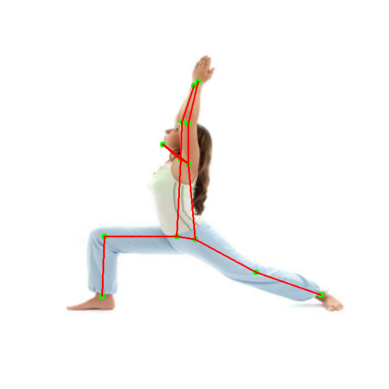

In [10]:
import matplotlib.pyplot as plt

connections = [
    (0, 1),  # Nose -> Left Shoulder
    (1, 9),  # Left Shoulder -> Left Elbow
    (9, 11), # Left Elbow -> Left Wrist
    (0, 2),  # Nose -> Right Shoulder
    (2, 10), # Right Shoulder -> Right Elbow
    (10, 12),# Right Elbow -> Right Wrist
    (1, 3),  # Left Shoulder -> Left Hip
    (2, 4),  # Right Shoulder -> Right Hip
    (3, 5),  # Left Hip -> Left Knee
    (5, 7),  # Left Knee -> Left Ankle
    (4, 6),  # Right Hip -> Right Knee
    (6, 8),   # Right Knee -> Right Ankle
    (1, 2),   # Left Shoulder -> Right Shoulder
    (3, 4)   # Left Hip -> Right Hip
]

# Visualization of the filtered keypoints
plt.imshow(image_rgb)
for x, y in mp_keypoints:
    cv2.circle(image_rgb, (x, y), 5, (0, 255, 0), -1)

for start_idx, end_idx in connections:
    start_point = mp_keypoints[start_idx]
    end_point = mp_keypoints[end_idx]
    cv2.line(image_rgb, start_point, end_point, (255, 0, 0), 2)  # Blue line with thickness 2

plt.axis('off')
plt.show()
